# **LSTM for yf stocks dataset**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf


class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,output_size):
    super().__init__()
    self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, _ = self.lstm(x)      # unpack tuple
    out = out[:, -1, :]        # last timestep
    out = self.fc(out)
    return out




In [2]:


data = yf.download("AAPL", start="2008-01-01", end="2024-01-01")
print(data.head())
prices = data['Close'].values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1,1))

X = prices_scaled[:-1]
y = prices_scaled[1:]

# Then create X_train, y_train, X_test, y_test from X and y

# X = prices[:-1]      # today
# y = prices[1:]       # tomorrow

n = int(0.8 * len(X))

X_train = X[:n]
y_train = y[:n]

X_test  = X[n:]
y_test  = y[n:]


X_train = torch.tensor(X_train).unsqueeze(-1).float()
y_train = torch.tensor(y_train).float()

X_test  = torch.tensor(X_test).unsqueeze(-1).float()
y_test  = torch.tensor(y_test).float()




/tmp/ipython-input-3535619814.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2008-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open      Volume
Ticker          AAPL      AAPL      AAPL      AAPL        AAPL
Date                                                          
2008-01-02  5.843455  6.006007  5.774776  5.976316  1079178800
2008-01-03  5.846154  5.919932  5.778974  5.860550   842066400
2008-01-04  5.399888  5.788272  5.365099  5.741786  1455832000
2008-01-07  5.327608  5.506355  5.105374  5.435875  2072193200
2008-01-08  5.135967  5.472167  5.122471  5.402587  1523816000


In [3]:
data.shape

(4027, 5)

In [4]:
data[1:5]

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2008-01-03,5.846154,5.919932,5.778974,5.860550,842066400
2008-01-04,5.399888,5.788272,5.365099,5.741786,1455832000
2008-01-07,5.327608,5.506355,5.105374,5.435875,2072193200
2008-01-08,5.135967,5.472167,5.122471,5.402587,1523816000


In [5]:
input_size = 1
hidden_size =512
num_layers = 2

lstm_model = LSTM(input_size, hidden_size, num_layers, output_size=1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)


In [6]:
def lstm_train(model, X, y, loss_fn, optimizer, batch_size, epochs):
    model.train()
    n = X.size(0)

    for epoch in range(epochs):
        total_loss = 0

        for i in range(0, n, batch_size):
            optimizer.zero_grad()

            x_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)

        print(f"Epoch {epoch+1} | Loss: {total_loss/n:.4f}")


In [7]:
def evaluate_model(model, X, y, batch_size=64):
    model.eval()
    loss_fn = nn.MSELoss()

    total_loss = 0
    n = X.size(0)

    with torch.no_grad():
        for i in range(0, n, batch_size):
            x_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            output = model(x_batch)
            loss = loss_fn(output, y_batch)

            total_loss += loss.item() * x_batch.size(0)

    return total_loss / n


In [8]:
lstm_losses = lstm_train(
    lstm_model,
    X_train,
    y_train,
    loss,
    optimizer,
    batch_size=64,
    epochs=15
)


Epoch 1 | Loss: 0.0018
Epoch 2 | Loss: 0.0252
Epoch 3 | Loss: 0.0239
Epoch 4 | Loss: 0.0121
Epoch 5 | Loss: 0.0116
Epoch 6 | Loss: 0.0080
Epoch 7 | Loss: 0.0047
Epoch 8 | Loss: 0.0010
Epoch 9 | Loss: 0.0006
Epoch 10 | Loss: 0.0005
Epoch 11 | Loss: 0.0005
Epoch 12 | Loss: 0.0004
Epoch 13 | Loss: 0.0004
Epoch 14 | Loss: 0.0004
Epoch 15 | Loss: 0.0003


In [9]:
evaluate_model(lstm_model, X_test, y_test)

0.0028589811585104053

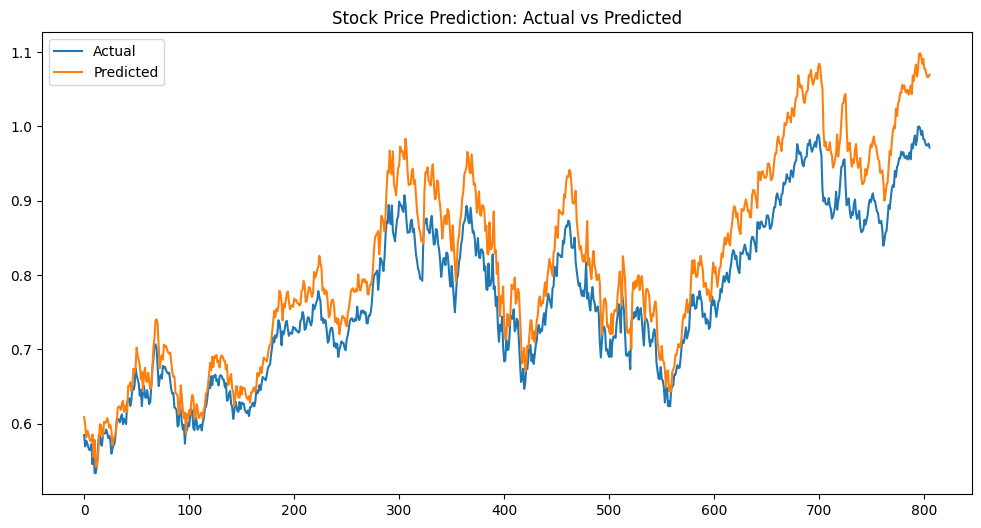

In [10]:
import matplotlib.pyplot as plt

# Make predictions on test set
lstm_model.eval()
with torch.no_grad():
    y_pred = lstm_model(X_test).squeeze().numpy()

# If you scaled data, inverse transform
# y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

plt.figure(figsize=(12,6))
plt.plot(y_test.numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Stock Price Prediction: Actual vs Predicted")
plt.show()


# **RNN**

In [11]:
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,output_size):
    super().__init__()
    self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, _ = self.rnn(x)      # unpack tuple
    out = out[:, -1, :]        # last timestep
    out = self.fc(out)
    return out

In [34]:
input_size = 5
hidden_size =256
num_layers = 4
rnn_model = RNN(input_size, hidden_size, num_layers, output_size=1)

In [35]:
# def rnn_train(model, X, y, loss_fn, optimizer, batch_size, epochs):
#     model.train()
#     n = X.size(0)

#     for epoch in range(epochs):
#         total_loss = 0

#         for i in range(0, n, batch_size):
#             optimizer.zero_grad()

#             x_batch = X[i:i+batch_size]
#             y_batch = y[i:i+batch_size]

#             output = model(x_batch)
#             loss = loss_fn(output, y_batch)

#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item() * x_batch.size(0)

#         print(f"Epoch {epoch+1} | Loss: {total_loss/n:.4f}")


In [36]:
# def evaluate_model(model, X, y, batch_size=64):
#     model.eval()
#     loss_fn = nn.MSELoss()

#     total_loss = 0
#     n = X.size(0)

#     with torch.no_grad():
#         for i in range(0, n, batch_size):
#             x_batch = X[i:i+batch_size]
#             y_batch = y[i:i+batch_size]

#             output = model(x_batch)
#             loss = loss_fn(output, y_batch)

#             total_loss += loss.item() * x_batch.size(0)

#     return total_loss / n


In [38]:
# rnn_losses = rnn_train(
#     rnn_model,
#     X_train,
#     y_train,
#     loss,
#     optimizer,
#     batch_size=64,
#     epochs=15
# )


In [32]:
# evaluate_model(rnn_model, X_test, y_test)

0.5614186091990979

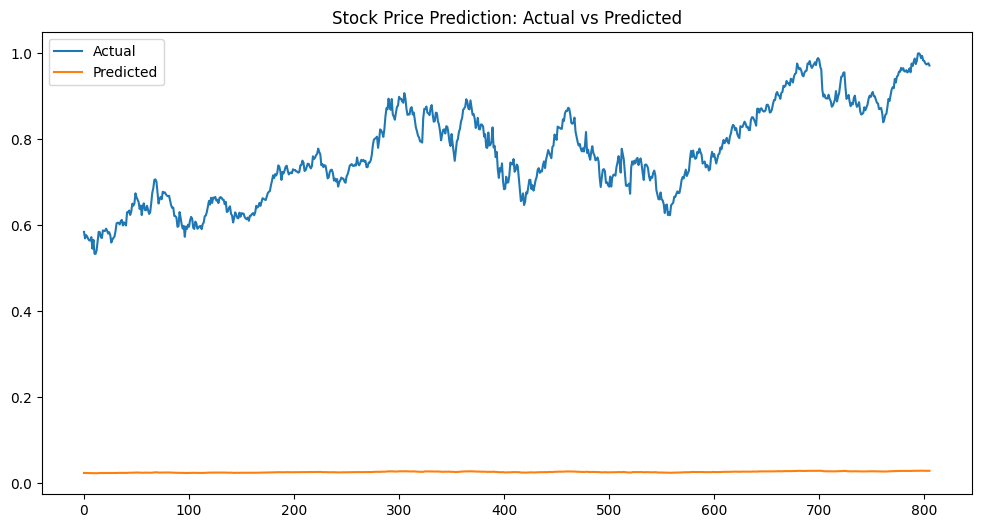

In [33]:
# import matplotlib.pyplot as plt

# # Make predictions on test set
# lstm_model.eval()
# with torch.no_grad():
#     y_pred = rnn_model(X_test).squeeze().numpy()

# # If you scaled data, inverse transform
# # y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
# # y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# plt.figure(figsize=(12,6))
# plt.plot(y_test.numpy(), label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.title("Stock Price Prediction: Actual vs Predicted")
# plt.show()
